Hong Fei Jin<br>
INSY 695 – Enterprise Data Science & ML in Production I<br>
Fatih Nayebi<br>
Sunday, February 12, 2023

# Assignment 2

## Preparing the Data (See Assignment 1)

In [1]:
# Import the data
import pandas as pd
df = pd.read_csv('SeoulBikeData.csv', encoding = 'mbcs')

In [2]:
# Get the weekday using the 'datetime' package
import numpy as np
from datetime import datetime

# Create empty column
df['Weekday'] = np.NaN

# Fill in weekdays
for i in range(len(df)):
    date = str(df['Date'][i])
    date_obj = datetime.strptime(date, '%d/%m/%Y').date()
    df['Weekday'][i] = date_obj.weekday()

C:\Users\jinho\AppData\Local\Temp\ipykernel_39712\609755345.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Weekday'][i] = date_obj.weekday()


In [3]:
# Split 'Date' into 'Day', 'Month', and 'Year'
df[['Day', 'Month', 'Year']] = df['Date'].str.split('/', expand = True)
df[['Day', 'Month', 'Year', 'Weekday']] = df[['Day', 'Month', 'Year', 'Weekday']].astype('int')

In [4]:
# Reorder columns for the sake of better visibility
cols = df.columns.tolist()
cols = cols[0:1] + cols[-4:] + cols[1:-4]
df = df[cols]

In [5]:
df = df[(df['Rainfall(mm)'] <= 2.5)]
df = df[(df['Snowfall (cm)'] <= 2.2)]
df = df[(df['Solar Radiation (MJ/m2)'] <= 2.33)]
df = df[(df['Wind speed (m/s)'] <= 4.4)]
df.shape

(7793, 18)

In [6]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(df, test_size = 0.2, random_state = 119)
print('Training set:', len(train_set))
print('Testing set:', len(test_set))

Training set: 6234
Testing set: 1559


In [7]:
bike = train_set.drop(['Rented Bike Count', 'Date', 'Dew point temperature(°C)'], axis = 1)
bike_labels = train_set['Rented Bike Count'].copy()

In [8]:
bike.shape

(6234, 15)

In [9]:
bike.head()

,Weekday,Day,Month,Year,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
100,1,5,12,2017,4,-7.2,34,3.0,2000,0.00,0.0,0.0,Winter,No Holiday,Yes
8486,0,19,11,2018,14,10.6,34,2.8,920,1.07,0.0,0.0,Autumn,No Holiday,Yes
4337,2,30,5,2018,17,24.1,41,2.2,1980,1.90,0.0,0.0,Spring,No Holiday,Yes
4700,3,14,6,2018,20,22.6,74,1.2,1594,0.01,0.0,0.0,Summer,No Holiday,Yes
7192,2,26,9,2018,16,24.4,35,1.8,2000,1.71,0.0,0.0,Autumn,No Holiday,Yes


In [10]:
bike_num = bike.select_dtypes(include = [np.number])
bike_cat = bike[['Seasons', 'Holiday', 'Functioning Day']]

In [11]:
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

num_pipeline = make_pipeline(SimpleImputer(strategy = 'median'), StandardScaler())
cat_pipeline = make_pipeline(SimpleImputer(strategy = 'most_frequent'), 
                             OneHotEncoder(handle_unknown = 'ignore'))

In [12]:
bike_num_clean = num_pipeline.fit_transform(bike_num)
bike_num_clean = pd.DataFrame(bike_num_clean, columns = list(bike_num.columns))

bike_cat_labels = ['Autumn', 'Spring', 'Summer', 'Winter', 'Holiday', 'No Holiday', 'No', 'Yes']
bike_cat_clean = cat_pipeline.fit_transform(bike_cat)
bike_cat_clean = pd.DataFrame(bike_cat_clean.toarray(), columns = bike_cat_labels)

In [17]:
bike_cleaned = pd.concat([bike_num_clean, bike_cat_clean], axis = 1, join = 'inner')
bike_cleaned = bike_cleaned.drop(['Autumn', 'No Holiday', 'No'], axis = 1)
bike_cleaned

,Weekday,Day,Month,Year,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Spring,Summer,Winter,Holiday,Yes
0,-1.006173,-1.207988,1.563015,-3.234124,-1.011668,-1.641680,-1.291095,1.452268,0.919984,-0.626638,-0.177791,-0.172022,0.0,0.0,1.0,0.0,1.0
1,-1.508292,0.380434,1.277657,0.309203,0.372269,-0.136938,-1.291095,1.241153,-0.855277,1.058043,-0.177791,-0.172022,0.0,0.0,0.0,0.0,1.0
2,-0.504053,1.628480,-0.434491,0.309203,0.787450,1.004299,-0.933634,0.607810,0.887108,2.364852,-0.177791,-0.172022,1.0,0.0,0.0,0.0,1.0
3,-0.001933,-0.186859,-0.149133,0.309203,1.202631,0.877495,0.751537,-0.447763,0.252617,-0.610893,-0.177791,-0.172022,0.0,1.0,0.0,0.0,1.0
4,-0.504053,1.174645,0.706941,0.309203,0.649056,1.029660,-1.240029,0.185580,0.919984,2.065703,-0.177791,-0.172022,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6229,-0.504053,1.174645,0.706941,0.309203,1.341024,0.564711,-0.831502,0.396695,0.919984,-0.626638,-0.177791,-0.172022,0.0,0.0,0.0,0.0,1.0
6230,1.002306,-1.548364,1.563015,-3.234124,-1.288455,-1.278175,1.364327,-0.131092,-0.302974,-0.626638,-0.177791,-0.172022,0.0,0.0,1.0,0.0,1.0
6231,-0.504053,0.607352,1.277657,0.309203,-0.873274,-0.458175,1.364327,-1.186665,-1.230055,-0.626638,-0.177791,-0.172022,0.0,0.0,0.0,0.0,1.0
6232,-0.504053,0.607352,-1.005207,0.309203,0.925843,-0.863948,0.904734,-0.342206,0.919984,-0.516425,-0.177791,-0.172022,1.0,0.0,0.0,0.0,1.0


## Calculate Average Treatment Effect (ATE)

In [15]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from xgboost import XGBRegressor
import warnings

from causalml.inference.meta import LRSRegressor
from causalml.inference.meta import XGBTRegressor, MLPTRegressor
from causalml.inference.meta import BaseXRegressor, BaseRRegressor, BaseSRegressor, BaseTRegressor
from causalml.match import NearestNeighborMatch, MatchOptimizer, create_table_one
from causalml.propensity import ElasticNetPropensityModel
from causalml.metrics import *

warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')

%matplotlib inline

In [78]:
X = bike_cleaned.drop('Holiday', axis = 1)
feature_names = X.columns
y = bike_labels
treatment = bike_cleaned['Holiday']

In [24]:
# Ready-to-use S-Learner using LinearRegression
learner_s = LRSRegressor()
ate_s = learner_s.estimate_ate(X = X, treatment = treatment, y = y)
print(ate_s)
print('ATE estimate: {:.03f}'.format(ate_s[0][0]))
print('ATE lower bound: {:.03f}'.format(ate_s[1][0]))
print('ATE upper bound: {:.03f}'.format(ate_s[2][0]))

# After calling estimate_ate, add pretrain=True flag to skip training
# This flag is applicable for other meta learner
ate_s = learner_s.estimate_ate(X = X, treatment = treatment, y = y, pretrain = True)
print(ate_s)
print('ATE estimate: {:.03f}'.format(ate_s[0][0]))
print('ATE lower bound: {:.03f}'.format(ate_s[1][0]))
print('ATE upper bound: {:.03f}'.format(ate_s[2][0]))

(array([-118.27700804]), array([-161.18607155]), array([-75.36794453]))
ATE estimate: -118.277
ATE lower bound: -161.186
ATE upper bound: -75.368
(array([-118.27700804]), array([-161.18607155]), array([-75.36794453]))
ATE estimate: -118.277
ATE lower bound: -161.186
ATE upper bound: -75.368


In [25]:
# Ready-to-use T-Learner using XGB
learner_t = XGBTRegressor()
ate_t = learner_t.estimate_ate(X=X, treatment=treatment, y=y)
print('Using the ready-to-use XGBTRegressor class')
print(ate_t)

# Calling the Base Learner class and feeding in XGB
learner_t = BaseTRegressor(learner=XGBRegressor())
ate_t = learner_t.estimate_ate(X=X, treatment=treatment, y=y)
print('\nUsing the BaseTRegressor class and using XGB (same result):')
print(ate_t)

# Calling the Base Learner class and feeding in LinearRegression
learner_t = BaseTRegressor(learner=LinearRegression())
ate_t = learner_t.estimate_ate(X=X, treatment=treatment, y=y)
print('\nUsing the BaseTRegressor class and using Linear Regression (different result):')
print(ate_t)

Using the ready-to-use XGBTRegressor class
(array([-185.01326314]), array([-196.16475934]), array([-173.86176694]))

Using the BaseTRegressor class and using XGB (same result):
(array([-185.01326314]), array([-196.16475934]), array([-173.86176694]))

Using the BaseTRegressor class and using Linear Regression (different result):
(array([-174.32442222]), array([-210.69439954]), array([-137.95444489]))


In [29]:
# X Learner without propensity score input
# Calling the Base Learner class and feeding in XGB
learner_x = BaseXRegressor(XGBRegressor())
ate_x = learner_x.estimate_ate(X=X, treatment=treatment, y=y)
print('Using the BaseXRegressor class and using XGB without propensity score input:')
print(ate_x)

# Calling the Base Learner class and feeding in LinearRegression
learner_x = BaseXRegressor(learner=LinearRegression())
ate_x = learner_x.estimate_ate(X=X, treatment=treatment, y=y)
print('\nUsing the BaseXRegressor class and using Linear Regression without propensity score input:')
print(ate_x)

Using the BaseXRegressor class and using XGB without propensity score input:
(array([-162.76235484]), array([-169.54807095]), array([-155.97663873]))

Using the BaseXRegressor class and using Linear Regression without propensity score input:
(array([-174.32442222]), array([-210.69439954]), array([-137.95444489]))


In [36]:
# R Learner without propensity score input
# Calling the Base Learner class and feeding in XGB
learner_r = BaseRRegressor(learner=XGBRegressor())
ate_r = learner_r.estimate_ate(X=X, treatment=treatment, y=y)
print('Using the BaseRRegressor class and using XGB without propensity score input:')
print(ate_r)

# Calling the Base Learner class and feeding in LinearRegression
learner_r = BaseRRegressor(learner=LinearRegression())
ate_r = learner_r.estimate_ate(X=X, treatment=treatment, y=y)
print('Using the BaseRRegressor class and using Linear Regression without propensity score input:')
print(ate_r)

Using the BaseRRegressor class and using XGB without propensity score input:
(array([-62.79338219]), array([-63.20995544]), array([-62.37680895]))
Using the BaseRRegressor class and using Linear Regression without propensity score input:
(array([-196.03816385]), array([-196.57629858]), array([-195.50002911]))


## Calculate Individual Treatment Effect (ITE / CATE)

In [37]:
# S Learner
learner_s = LRSRegressor()
cate_s = learner_s.fit_predict(X=X, treatment=treatment, y=y)

# T Learner
learner_t = BaseTRegressor(learner=XGBRegressor())
cate_t = learner_t.fit_predict(X=X, treatment=treatment, y=y)

# X Learner without propensity score input
learner_x_no_p = BaseXRegressor(learner=XGBRegressor())
cate_x_no_p = learner_x_no_p.fit_predict(X=X, treatment=treatment, y=y)

# R Learner without propensity score input
learner_r_no_p = BaseRRegressor(learner=XGBRegressor())
cate_r_no_p = learner_r_no_p.fit_predict(X=X, treatment=treatment, y=y)

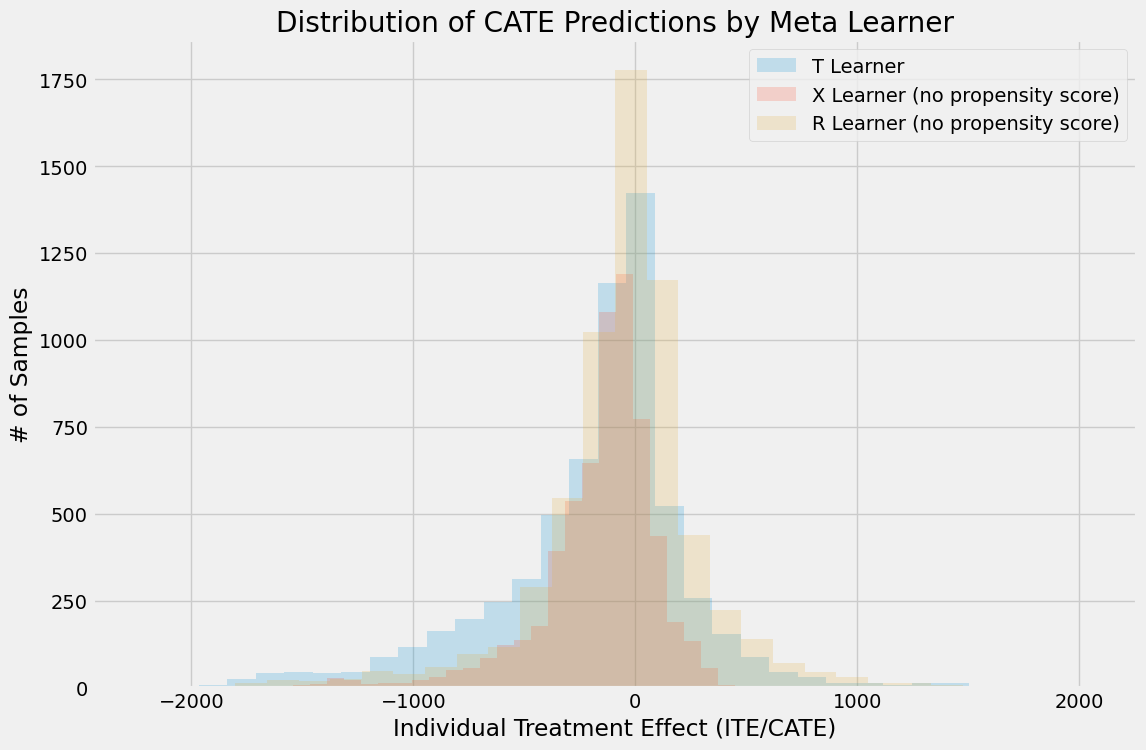

In [46]:
alpha=0.2
bins=30
plt.figure(figsize=(12,8))
plt.hist(cate_t, alpha=alpha, bins=bins, label='T Learner')
plt.hist(cate_x_no_p, alpha=alpha, bins=bins, label='X Learner (no propensity score)')
plt.hist(cate_r_no_p, alpha=alpha, bins=bins, label='R Learner (no propensity score)')
plt.title('Distribution of CATE Predictions by Meta Learner')
plt.xlabel('Individual Treatment Effect (ITE/CATE)')
plt.ylabel('# of Samples')
_=plt.legend()
plt.show()

### S Learner

In [65]:
multi_treatment = np.array(['Holiday' if x == 1 else 'control' for x in treatment])

base_algo = LGBMRegressor()
# base_algo = XGBRegressor()
# base_algo = RandomForestRegressor()
# base_algo = LinearRegression()

slearner = BaseSRegressor(base_algo, control_name = 'control')
slearner.estimate_ate(X, multi_treatment, y)

array([-112.68440478])

In [80]:
slearner_tau = slearner.fit_predict(X, multi_treatment, y)
slearner.get_importance(X=X, 
                        tau=slearner_tau,
                        normalize=True, 
                        method='auto', features = feature_names)

{'Holiday': Hour                       0.530344
 Solar Radiation (MJ/m2)    0.150118
 Weekday                    0.114532
 Temperature(°C)            0.060298
 Month                      0.035458
 Humidity(%)                0.034582
 Yes                        0.030554
 Winter                     0.017327
 Day                        0.014395
 Rainfall(mm)               0.005048
 Visibility (10m)           0.004661
 Wind speed (m/s)           0.001566
 Summer                     0.000871
 Spring                     0.000170
 Snowfall (cm)              0.000077
 Year                       0.000000
 dtype: float64}

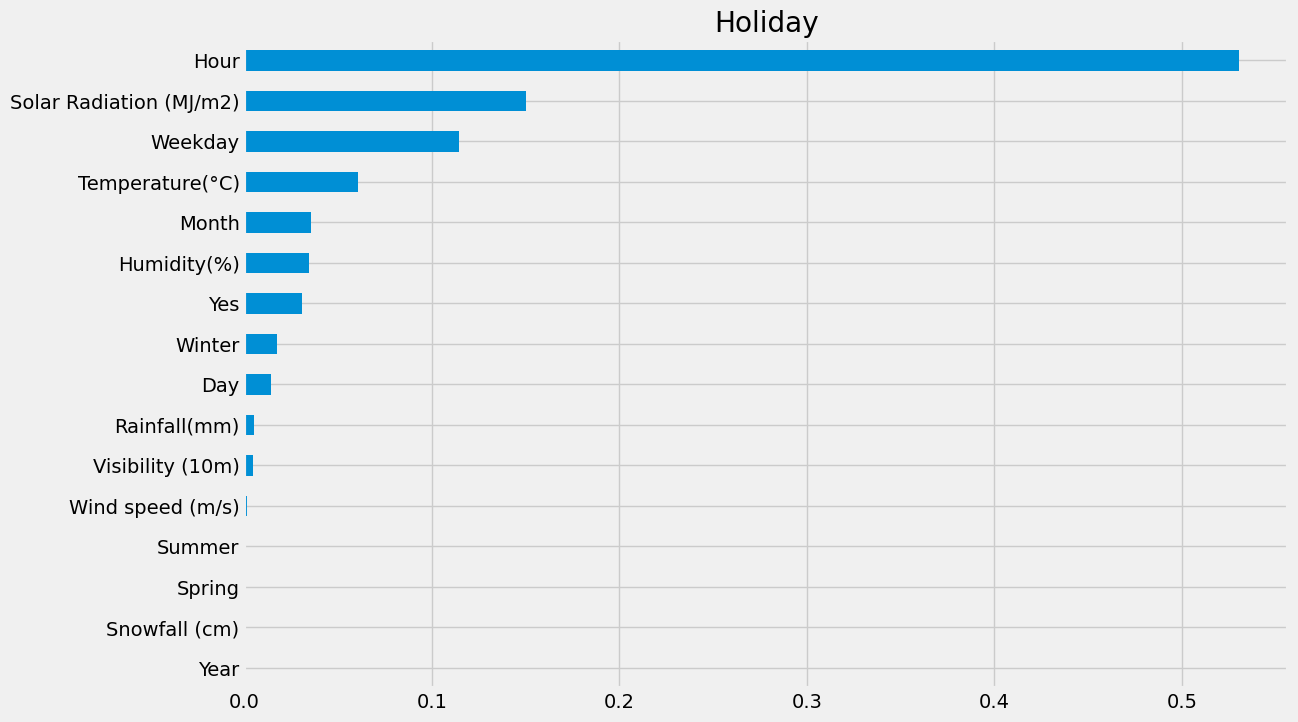

In [81]:
slearner.plot_importance(X=X, 
                         tau=slearner_tau, 
                         normalize=True, 
                         method='auto', 
                         features=feature_names)

In [82]:
slearner.get_importance(X=X, 
                        tau=slearner_tau, 
                        method='permutation', 
                        features=feature_names, 
                        random_state=119)

{'Holiday': Hour                       1.531113
 Weekday                    0.275150
 Solar Radiation (MJ/m2)    0.267107
 Temperature(°C)            0.131237
 Yes                        0.107874
 Month                      0.073780
 Humidity(%)                0.070309
 Day                        0.028122
 Winter                     0.014838
 Visibility (10m)           0.005531
 Rainfall(mm)               0.005167
 Wind speed (m/s)           0.002125
 Spring                     0.000353
 Summer                     0.000202
 Snowfall (cm)              0.000077
 Year                       0.000000
 dtype: float64}

In [83]:
import time
start_time = time.time()

slearner.get_importance(X=X, 
                        tau=slearner_tau, 
                        method='permutation', 
                        features=feature_names, 
                        random_state=42)

print("Elapsed time: %s seconds" % (time.time() - start_time))

Elapsed time: 0.245042085647583 seconds


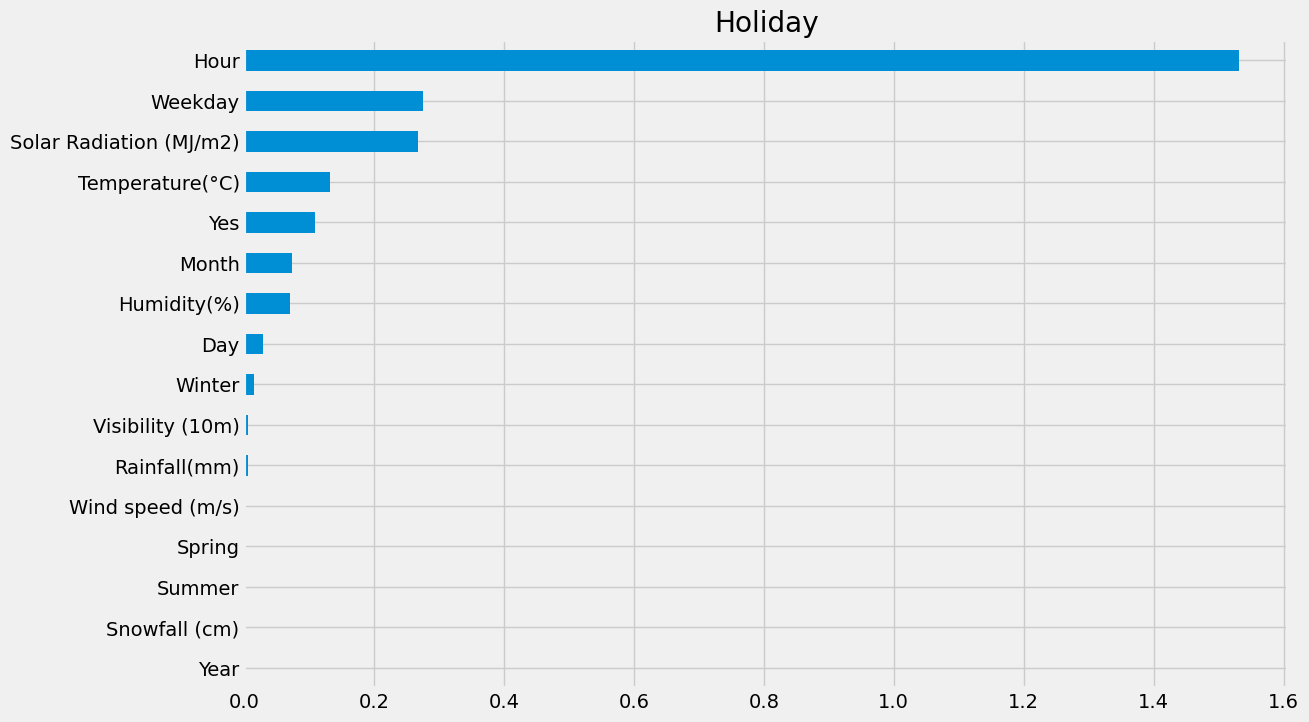

In [84]:
slearner.plot_importance(X=X, 
                         tau=slearner_tau, 
                         method='permutation', 
                         features=feature_names, 
                         random_state=119)

In [87]:
import time
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split

start_time = time.time()

model_tau = LGBMRegressor(importance_type='gain')
X_train, X_test, y_train, y_test = train_test_split(X, slearner_tau, test_size=0.3, random_state=42)
model_tau_fit = model_tau.fit(X_train, y_train)

perm_imp_test = permutation_importance(
    estimator=model_tau_fit, 
    X=X_test, 
    y=y_test, 
    random_state=42).importances_mean
pd.Series(perm_imp_test, feature_names).sort_values(ascending=False)

print("Elapsed time: %s seconds" % (time.time() - start_time))

Elapsed time: 0.30452990531921387 seconds


In [89]:
pd.Series(perm_imp_test, feature_names).sort_values(ascending=False)

Hour                       1.507623
Weekday                    0.290833
Solar Radiation (MJ/m2)    0.231167
Temperature(°C)            0.140109
Yes                        0.090805
Month                      0.068758
Humidity(%)                0.068719
Day                        0.027108
Winter                     0.024145
Rainfall(mm)               0.007812
Visibility (10m)           0.004930
Wind speed (m/s)           0.002433
Spring                     0.000942
Summer                     0.000195
Snowfall (cm)              0.000028
Year                       0.000000
dtype: float64

Text(0.5, 1.0, 'Test Set Permutation Importances')

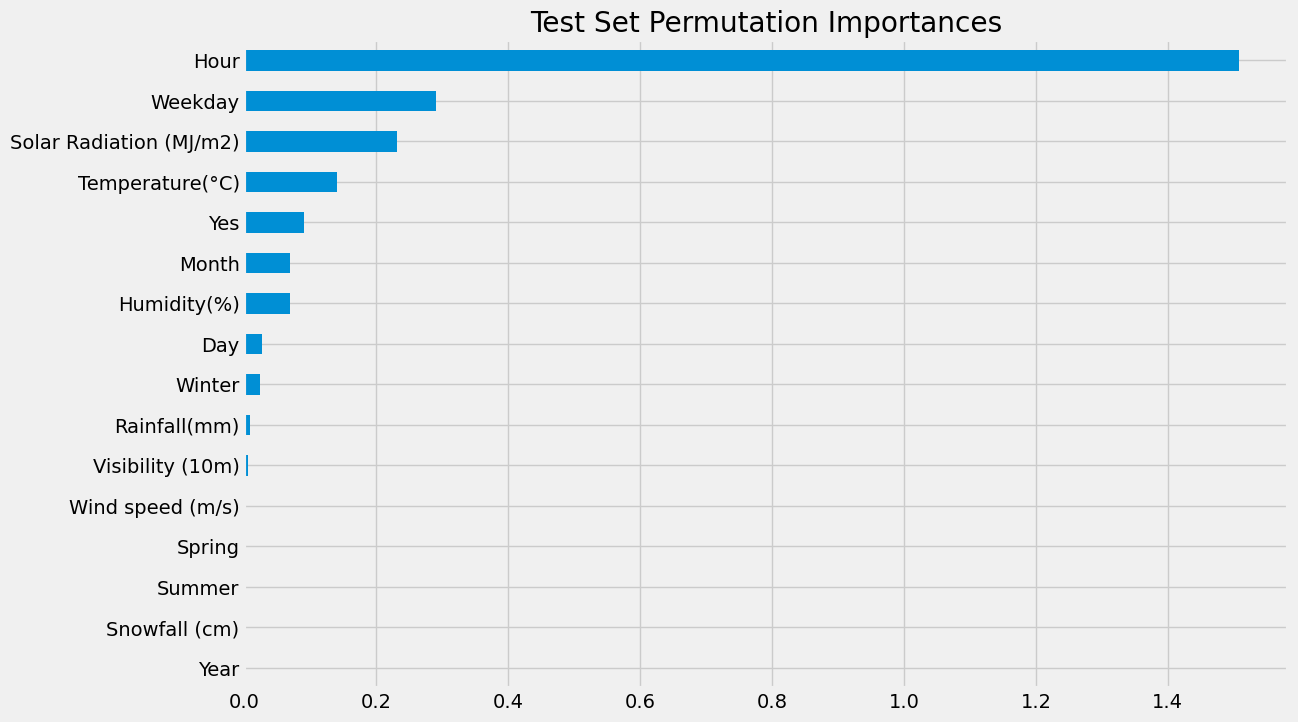

In [90]:
pd.Series(perm_imp_test, feature_names).sort_values().plot(kind='barh', figsize=(12, 8))
plt.title('Test Set Permutation Importances')

In [91]:
perm_imp_train = permutation_importance(
    estimator=model_tau_fit, 
    X=X_train, 
    y=y_train, 
    random_state=42).importances_mean
pd.Series(perm_imp_train, feature_names).sort_values(ascending=False)

Hour                       1.480794
Weekday                    0.275744
Solar Radiation (MJ/m2)    0.223319
Temperature(°C)            0.137078
Yes                        0.085992
Humidity(%)                0.073465
Month                      0.069738
Day                        0.027398
Winter                     0.022423
Visibility (10m)           0.006916
Rainfall(mm)               0.005432
Wind speed (m/s)           0.002986
Spring                     0.000937
Summer                     0.000139
Snowfall (cm)              0.000074
Year                       0.000000
dtype: float64

Text(0.5, 1.0, 'Training Set Permutation Importances')

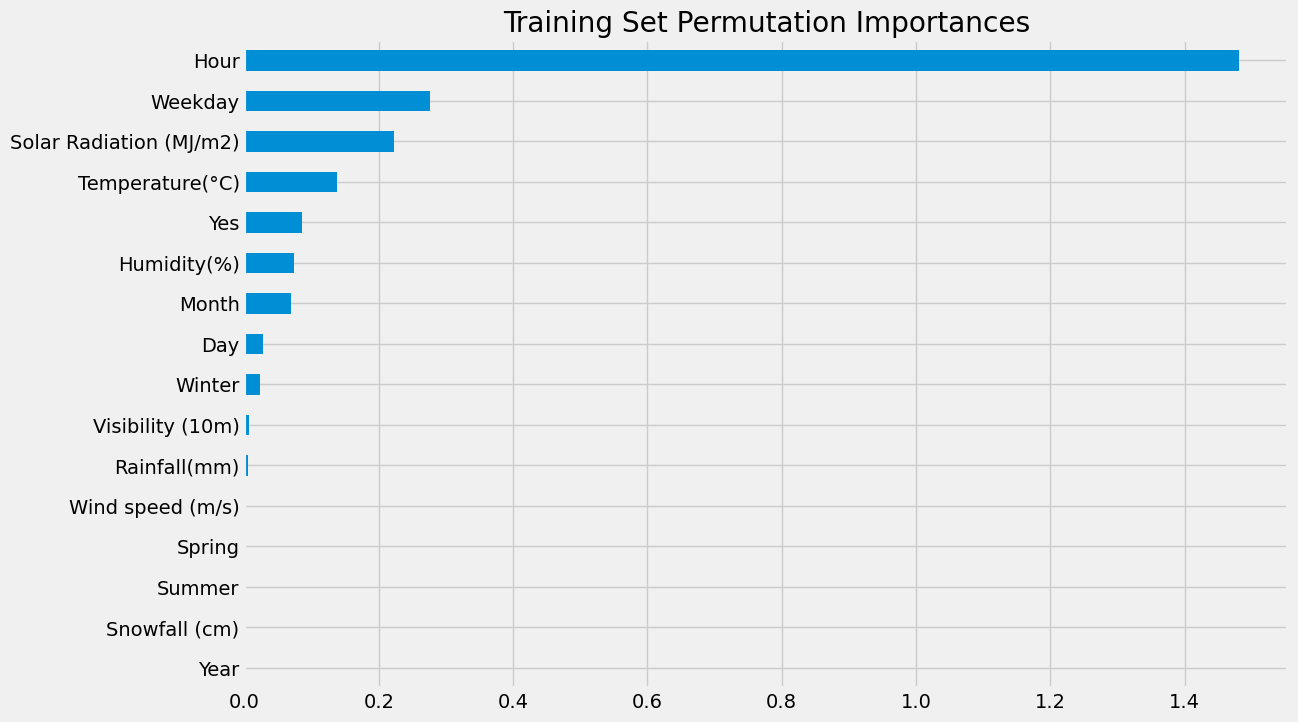

In [92]:
pd.Series(perm_imp_train, feature_names).sort_values().plot(kind='barh', figsize=(12, 8))
plt.title('Training Set Permutation Importances')

In [93]:
shap_slearner = slearner.get_shap_values(X=X, tau=slearner_tau)
shap_slearner

{'Holiday': array([[ -1.21803325,  16.03487363,  12.02180712, ...,  -0.16649296,
          10.68797685,  -2.11318951],
        [ -3.10889471, -10.56117756,   6.4161229 , ...,  -0.73955856,
          -7.19862723,  -4.39128361],
        [-11.44721916, -20.85092519, -10.97467743, ...,  -0.78514836,
          -6.10424061,  -5.52477959],
        ...,
        [ -5.29186152,  -6.83384601,  -2.53464416, ...,  -0.21758892,
          -3.73834946,  -2.96419814],
        [-24.57059877,  -6.85836221,  30.05034123, ...,  -0.58419392,
          -6.33064035,  -5.43843796],
        [-16.29947129,  -8.18610675,  30.77081785, ...,  -0.37556802,
          -3.88113972,  -5.24969785]])}

In [95]:
np.mean(np.abs(shap_slearner['Holiday']),axis=0)

array([20.37405054, 11.86062633, 15.27968093,  0.        , 92.32323978,
       20.40658499, 16.72592082,  1.92646578,  3.76581623, 19.16186149,
        2.93116882,  0.12440951,  0.3161975 ,  0.706377  ,  8.5927378 ,
        8.36128142])

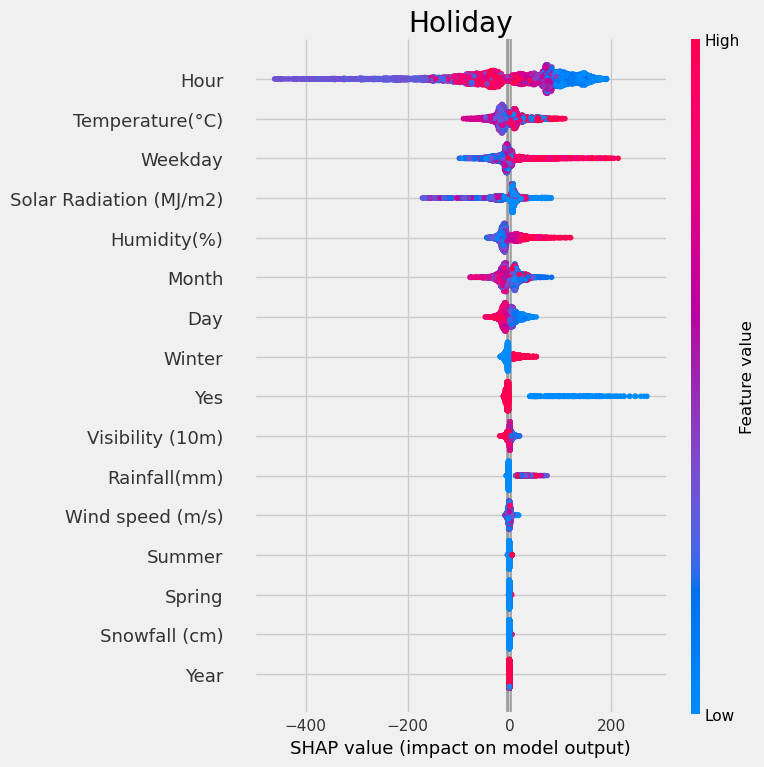

In [96]:
# Plot shap values without specifying shap_dict
slearner.plot_shap_values(X=X, tau=slearner_tau, features=feature_names)

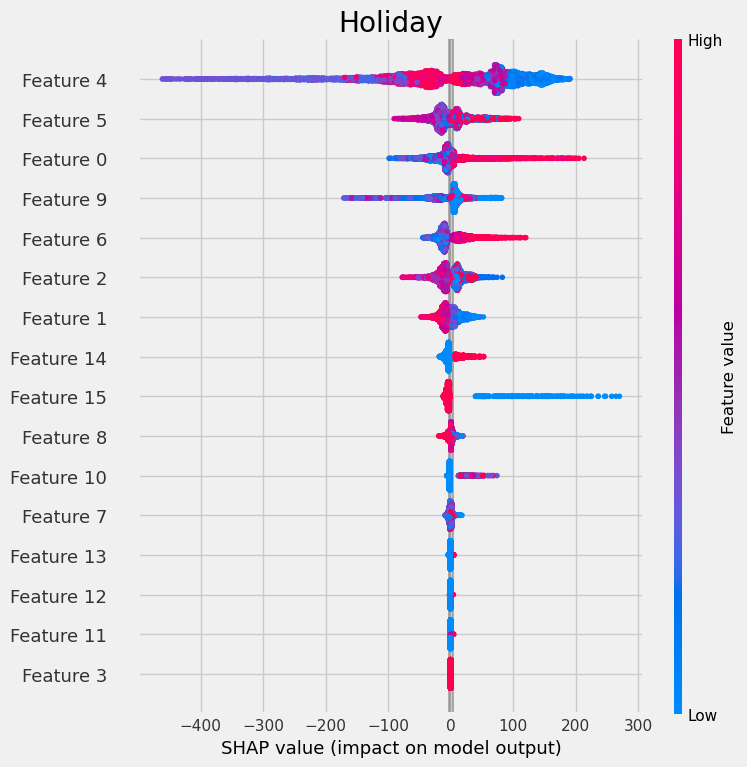

In [97]:
# Plot shap values WITH specifying shap_dict
slearner.plot_shap_values(X=X, shap_dict=shap_slearner)

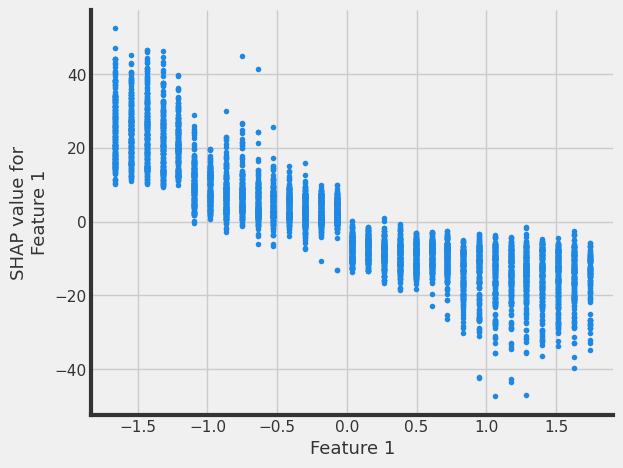

In [99]:
# interaction_idx set to None (no color coding for interaction effects)
slearner.plot_shap_dependence(treatment_group='Holiday',
                              feature_idx=1,
                              X=X,
                              tau=slearner_tau,
                              interaction_idx=None,
                              shap_dict=shap_slearner)

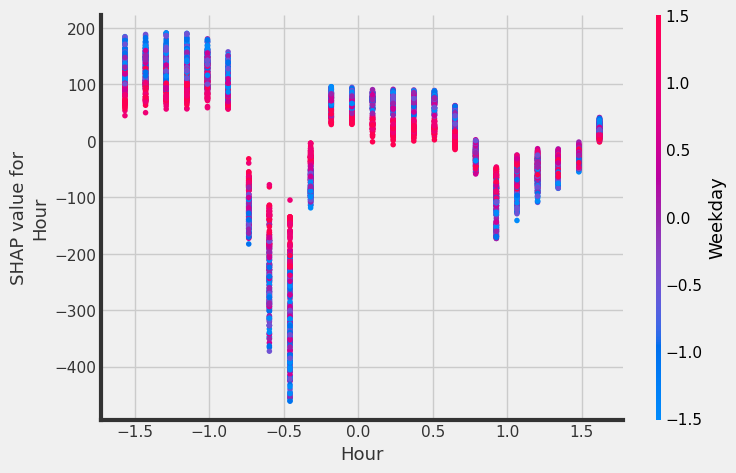

In [101]:
# interaction_idx set to 'auto' (searches for feature with greatest approximate interaction)
# specify feature names
slearner.plot_shap_dependence(treatment_group='Holiday',
                              feature_idx='Hour',
                              X=X,
                              tau=slearner_tau,
                              interaction_idx='auto',
                              shap_dict=shap_slearner,
                              features=feature_names)

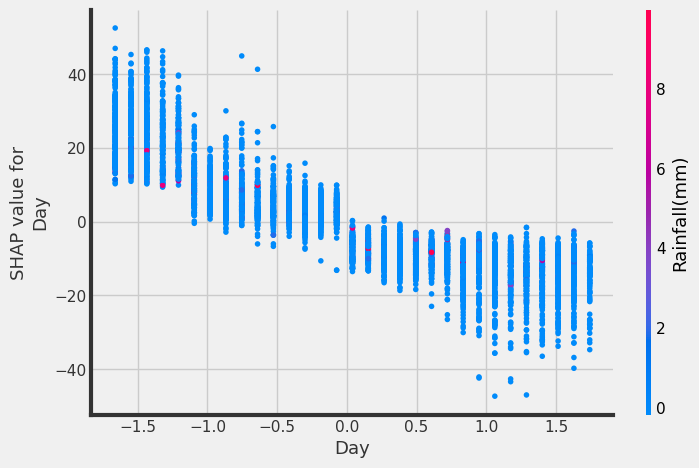

In [102]:
# interaction_idx set to specific index
slearner.plot_shap_dependence(treatment_group='Holiday',
                              feature_idx=1,
                              X=X,
                              tau=slearner_tau,
                              interaction_idx=10,
                              shap_dict=shap_slearner, 
                              features=feature_names)

### T Learner

In [107]:
tlearner = BaseTRegressor(LGBMRegressor(), control_name='control')
tlearner.estimate_ate(X, multi_treatment, y)

(array([-126.44840249]), array([-141.51000209]), array([-111.38680289]))

In [108]:
tlearner_tau = tlearner.fit_predict(X, multi_treatment, y)
tlearner.get_importance(X=X, 
                        tau=tlearner_tau, 
                        normalize=True, 
                        method='auto', 
                        features=feature_names)

{'Holiday': Hour                       0.268733
 Temperature(°C)            0.244841
 Day                        0.089232
 Yes                        0.083128
 Month                      0.058971
 Weekday                    0.055904
 Winter                     0.053235
 Rainfall(mm)               0.046149
 Humidity(%)                0.045928
 Solar Radiation (MJ/m2)    0.037946
 Wind speed (m/s)           0.007746
 Visibility (10m)           0.005911
 Summer                     0.001543
 Spring                     0.000450
 Snowfall (cm)              0.000284
 Year                       0.000000
 dtype: float64}

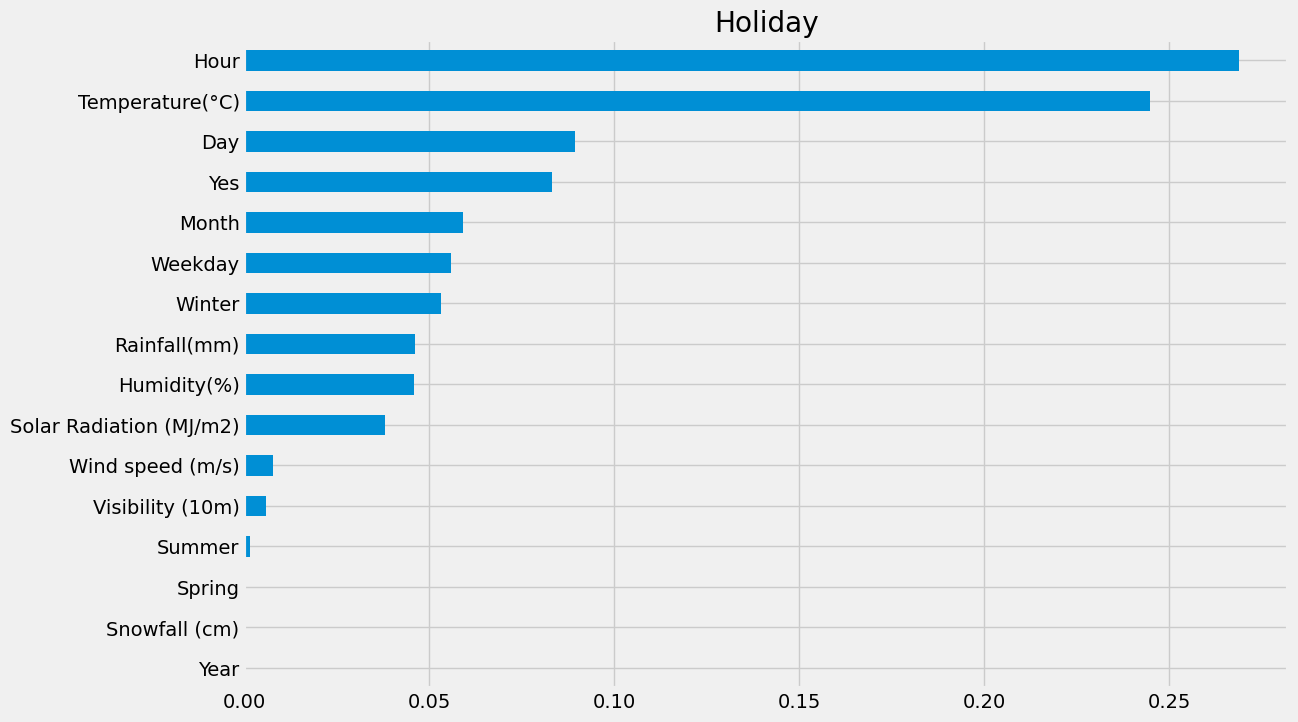

In [109]:
tlearner.plot_importance(X=X, 
                         tau=tlearner_tau, 
                         normalize=True, 
                         method='auto', 
                         features=feature_names)

In [110]:
tlearner.get_importance(X=X, 
                        tau=tlearner_tau, 
                        method='permutation', 
                        features=feature_names, 
                        random_state=119)

{'Holiday': Hour                       0.700597
 Temperature(°C)            0.629344
 Yes                        0.310611
 Day                        0.185688
 Weekday                    0.155926
 Month                      0.097251
 Winter                     0.090869
 Humidity(%)                0.086541
 Solar Radiation (MJ/m2)    0.070599
 Rainfall(mm)               0.057850
 Wind speed (m/s)           0.010589
 Visibility (10m)           0.006634
 Summer                     0.002145
 Spring                     0.000407
 Snowfall (cm)              0.000369
 Year                       0.000000
 dtype: float64}

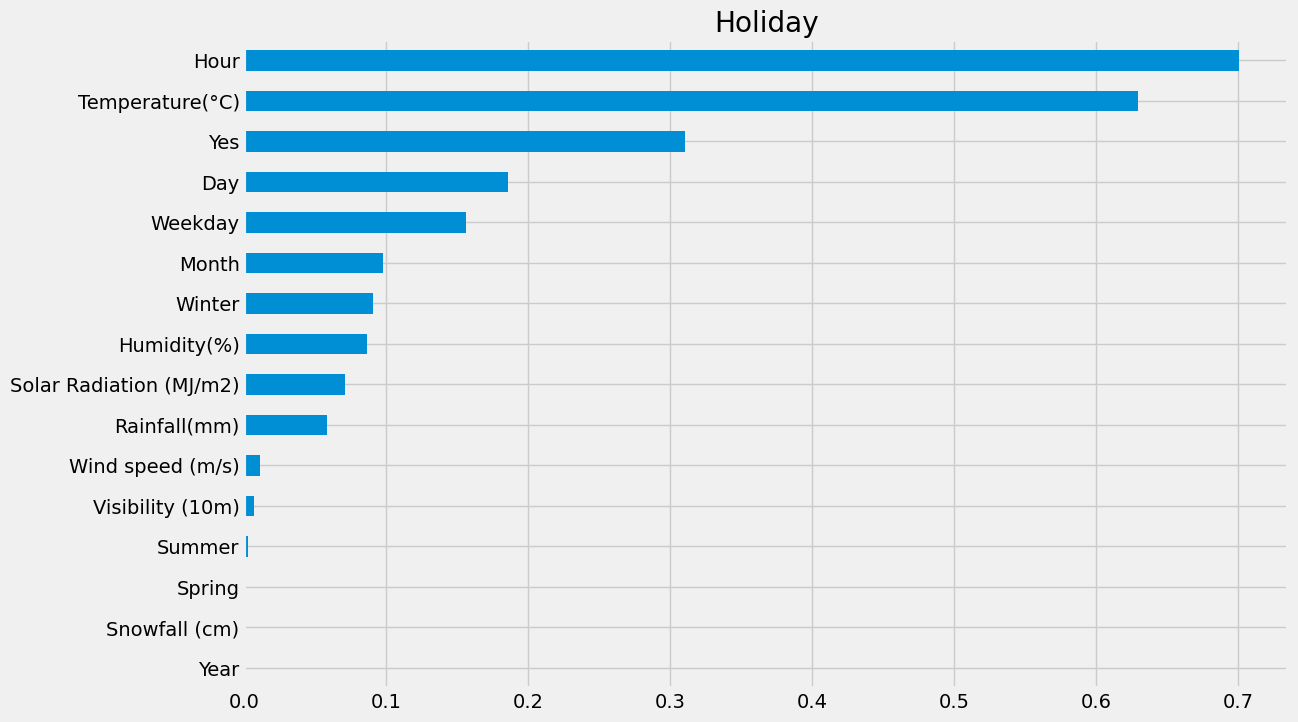

In [111]:
tlearner.plot_importance(X=X, 
                         tau=tlearner_tau, 
                         method='permutation', 
                         features=feature_names, 
                         random_state=119)

In [112]:
start_time = time.time()

X_train, X_test, y_train, y_test = train_test_split(X, tlearner_tau, test_size=0.3, random_state=42)
model_tau_fit = model_tau.fit(X_train, y_train)

perm_imp_test = permutation_importance(
    estimator=model_tau_fit, 
    X=X_test, 
    y=y_test, 
    random_state=42).importances_mean
pd.Series(perm_imp_test, feature_names).sort_values(ascending=False)

print("Elapsed time: %s seconds" % (time.time() - start_time))

Elapsed time: 0.3307015895843506 seconds


In [113]:
pd.Series(perm_imp_test, feature_names).sort_values(ascending=False)

Hour                       0.739236
Temperature(°C)            0.678932
Yes                        0.297858
Day                        0.195930
Weekday                    0.163775
Winter                     0.112010
Month                      0.103433
Humidity(%)                0.097180
Solar Radiation (MJ/m2)    0.067989
Rainfall(mm)               0.056002
Wind speed (m/s)           0.010671
Visibility (10m)           0.006243
Summer                     0.002203
Spring                     0.000985
Snowfall (cm)              0.000402
Year                       0.000000
dtype: float64

Text(0.5, 1.0, 'Test Set Permutation Importances')

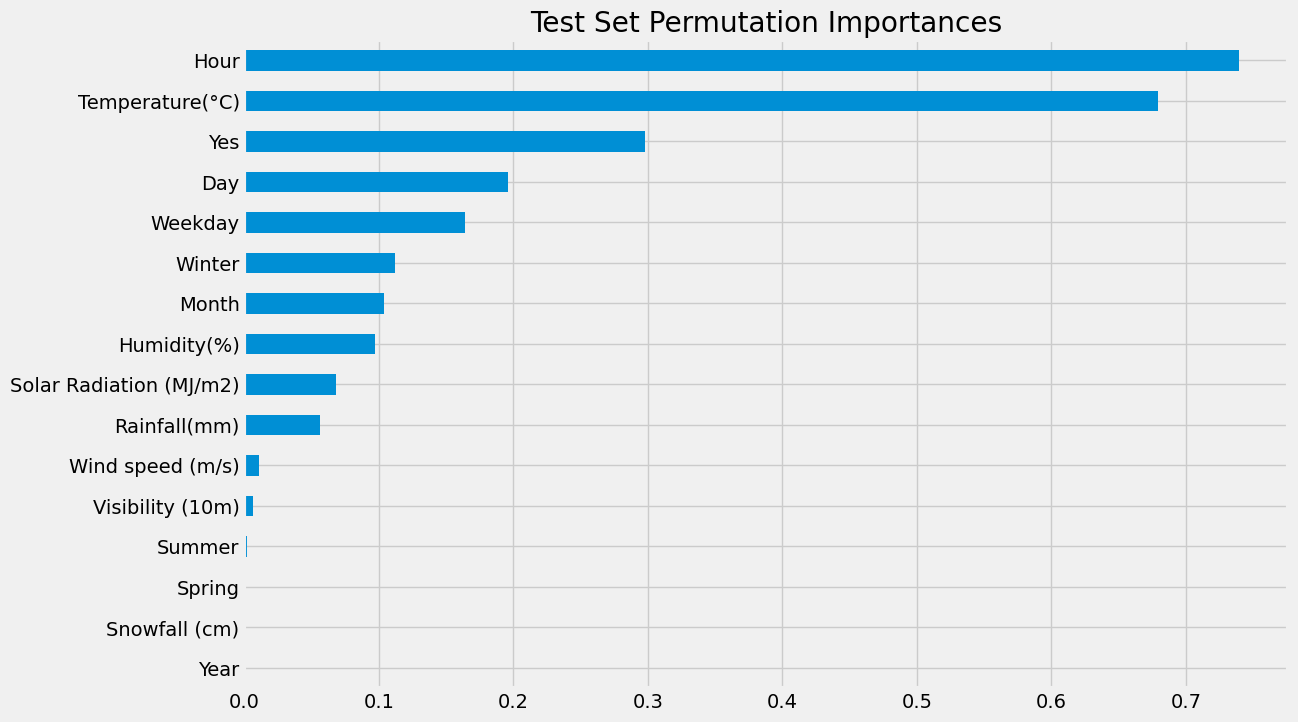

In [114]:
pd.Series(perm_imp_test, feature_names).sort_values().plot(kind='barh', figsize=(12, 8))
plt.title('Test Set Permutation Importances')

In [115]:
shap_tlearner = tlearner.get_shap_values(X=X, tau=tlearner_tau)
shap_tlearner

{'Holiday': array([[ -9.59451365, 164.00029886, -24.63735623, ...,   2.92037872,
          58.40014912, -19.13292722],
        [  7.17918727, -98.76470348, -46.94302641, ...,   0.86477828,
         -77.41250958, -28.25691418],
        [-10.50094911,  53.80445221, -50.19858073, ...,   2.27006926,
         -51.54950754, -41.10781478],
        ...,
        [-18.88194991, -49.40495883, -32.7268397 , ...,   3.79689993,
         -29.94201515, -11.56611196],
        [-65.21442369, -35.76758465, 140.88428654, ...,   2.31945221,
         -77.75051107, -27.02905195],
        [-42.58004587, -51.50008057,  58.87165008, ...,   2.77416544,
         -32.29230131, -12.47402516]])}

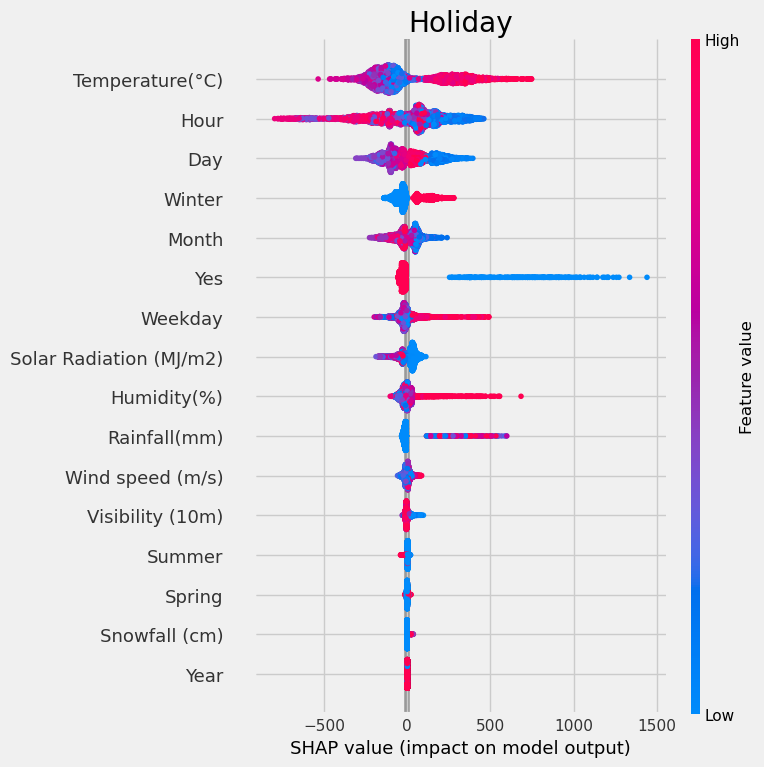

In [116]:
# Plot shap values without specifying shap_dict
tlearner.plot_shap_values(X=X, tau=tlearner_tau, features=feature_names)

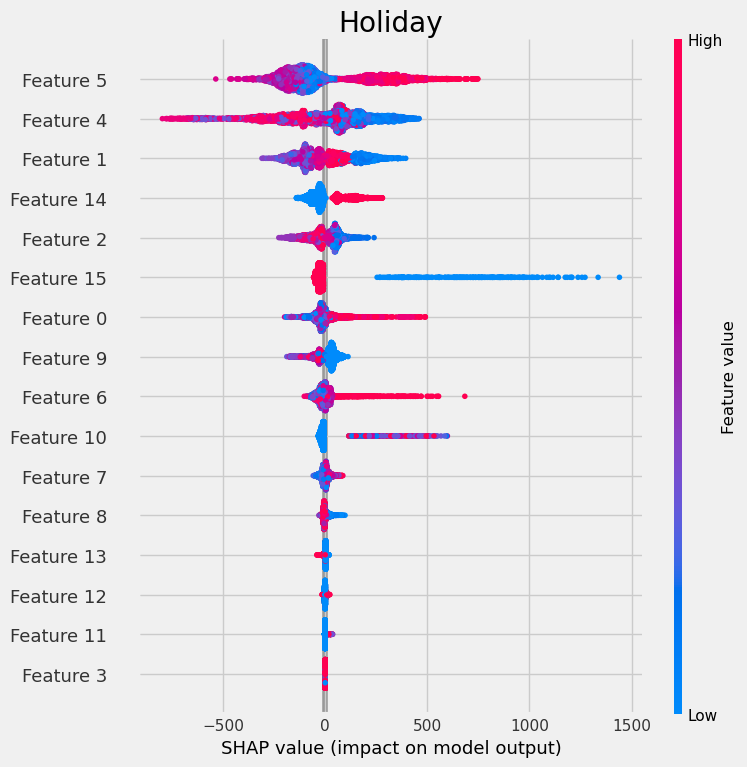

In [117]:
# Plot shap values WITH specifying shap_dict
tlearner.plot_shap_values(X=X, shap_dict=shap_tlearner)

### X Learner

In [119]:
xlearner = BaseXRegressor(LGBMRegressor(), control_name='control')
xlearner.estimate_ate(X, multi_treatment, y)

(array([-172.18265888]), array([-182.78604642]), array([-161.57927133]))

In [122]:
xlearner_tau = xlearner.predict(X, multi_treatment, y)
xlearner.get_importance(X=X, 
                        tau=xlearner_tau, 
                        normalize=True, 
                        method='auto', 
                        features=feature_names)

{'Holiday': Hour                       0.477771
 Solar Radiation (MJ/m2)    0.201217
 Day                        0.107287
 Month                      0.064875
 Temperature(°C)            0.058901
 Weekday                    0.041281
 Humidity(%)                0.013432
 Visibility (10m)           0.009359
 Summer                     0.008968
 Yes                        0.008046
 Wind speed (m/s)           0.007082
 Spring                     0.000966
 Winter                     0.000654
 Rainfall(mm)               0.000146
 Snowfall (cm)              0.000015
 Year                       0.000000
 dtype: float64}

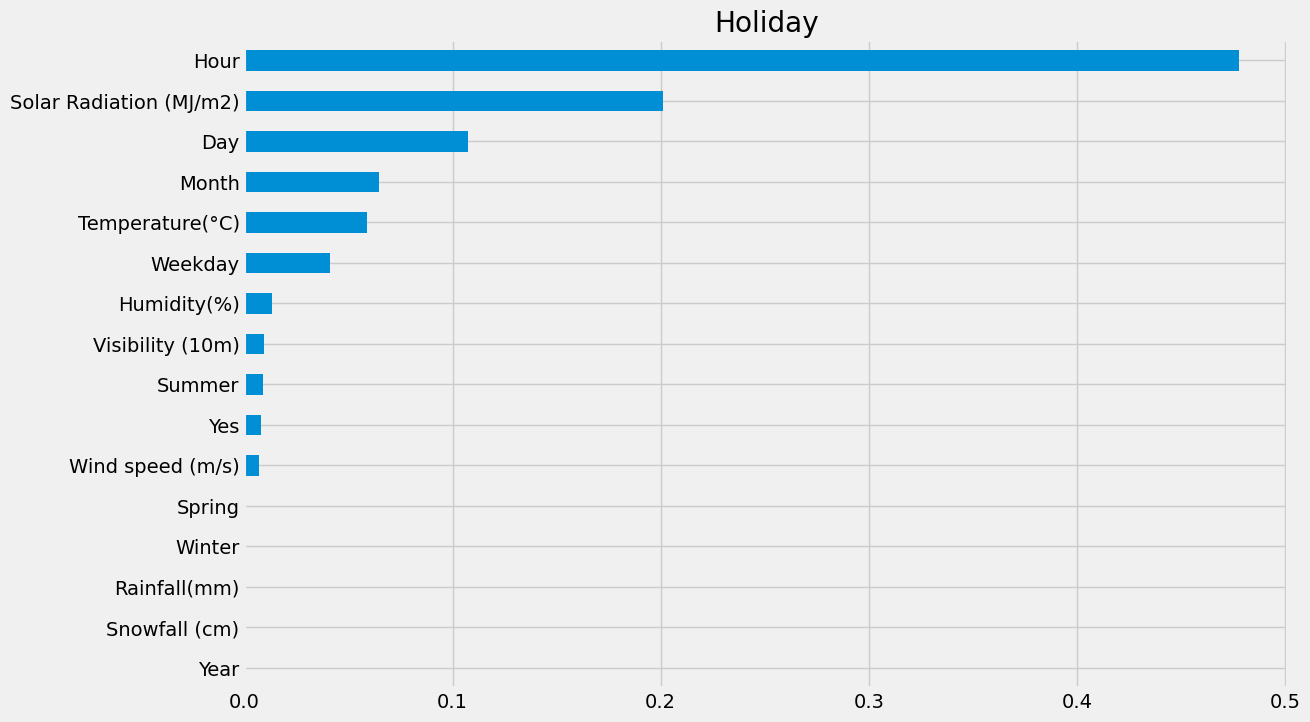

In [123]:
xlearner.plot_importance(X=X, 
                         tau=xlearner_tau, 
                         normalize=True, 
                         method='auto', 
                         features=feature_names)

In [124]:
xlearner.get_importance(X=X, 
                        tau=xlearner_tau, 
                        method='permutation', 
                        features=feature_names, 
                        random_state=119)

{'Holiday': Hour                       1.051647
 Solar Radiation (MJ/m2)    0.388565
 Day                        0.222674
 Month                      0.111695
 Weekday                    0.076918
 Temperature(°C)            0.072695
 Summer                     0.020829
 Yes                        0.019005
 Humidity(%)                0.017791
 Visibility (10m)           0.017523
 Wind speed (m/s)           0.011489
 Winter                     0.001135
 Spring                     0.000372
 Snowfall (cm)              0.000042
 Rainfall(mm)               0.000038
 Year                       0.000000
 dtype: float64}

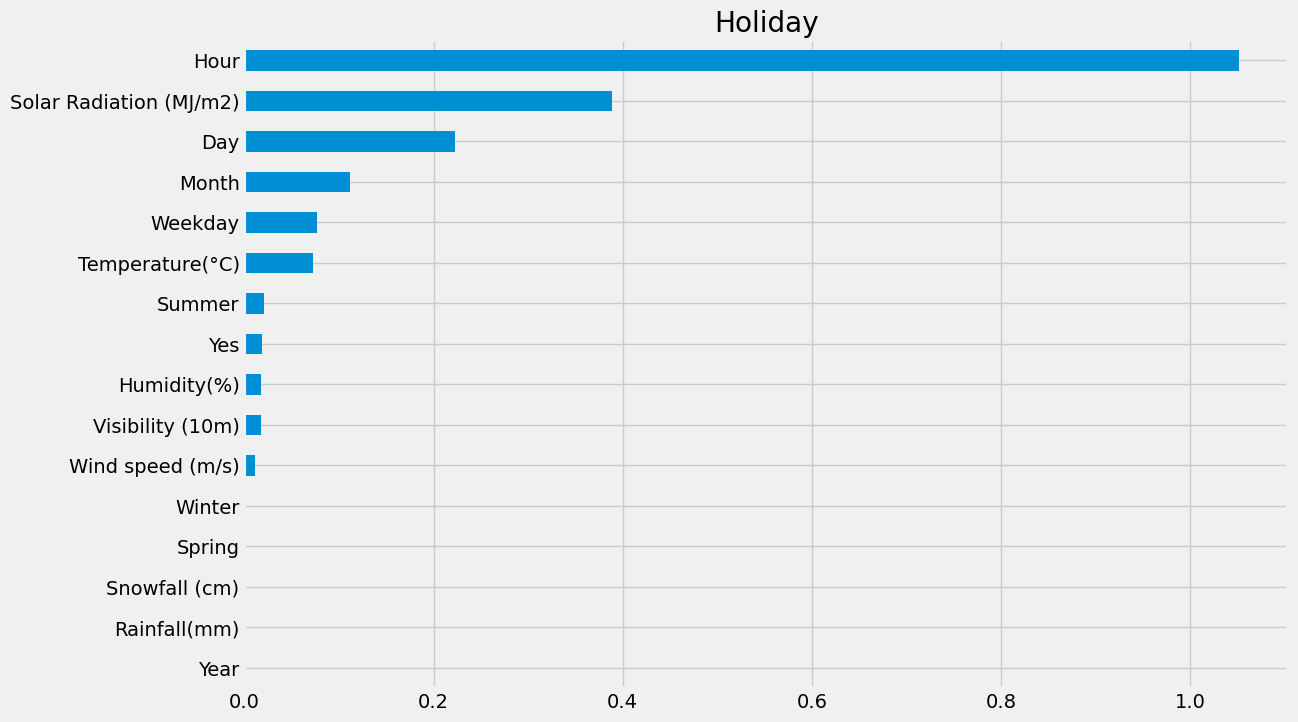

In [126]:
xlearner.plot_importance(X=X, 
                         tau=xlearner_tau, 
                         method='permutation', 
                         features=feature_names, 
                         random_state=119)

In [127]:
start_time = time.time()

X_train, X_test, y_train, y_test = train_test_split(X, xlearner_tau, test_size=0.3, random_state=42)
model_tau_fit = model_tau.fit(X_train, y_train)

perm_imp_test = permutation_importance(
    estimator=model_tau_fit, 
    X=X_test, 
    y=y_test, 
    random_state=42).importances_mean
pd.Series(perm_imp_test, feature_names).sort_values(ascending=False)

print("Elapsed time: %s seconds" % (time.time() - start_time))

Elapsed time: 0.3249175548553467 seconds


In [128]:
pd.Series(perm_imp_test, feature_names).sort_values(ascending=False)

Hour                       1.089893
Solar Radiation (MJ/m2)    0.373099
Day                        0.224902
Month                      0.132319
Weekday                    0.084063
Temperature(°C)            0.065491
Humidity(%)                0.020140
Visibility (10m)           0.018526
Yes                        0.014146
Summer                     0.012605
Wind speed (m/s)           0.011967
Winter                     0.001129
Spring                     0.000422
Rainfall(mm)               0.000299
Year                       0.000000
Snowfall (cm)              0.000000
dtype: float64

Text(0.5, 1.0, 'Test Set Permutation Importances')

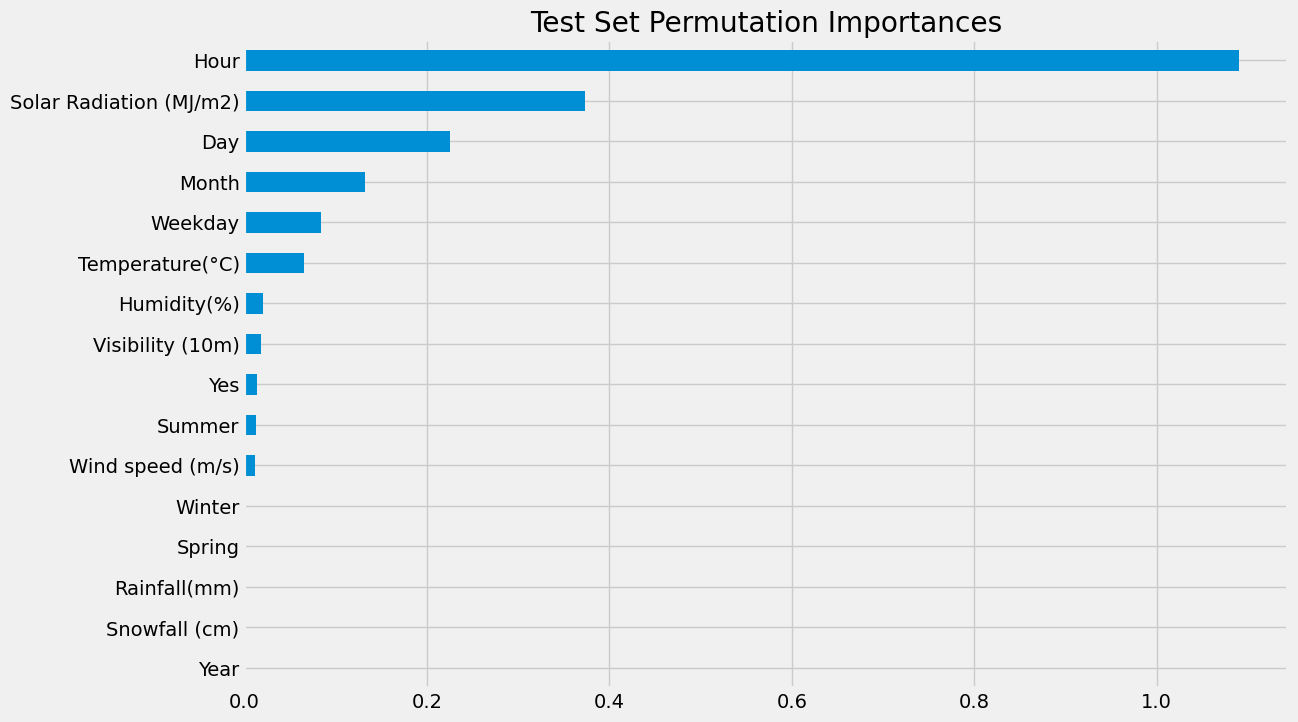

In [129]:
pd.Series(perm_imp_test, feature_names).sort_values().plot(kind='barh', figsize=(12, 8))
plt.title('Test Set Permutation Importances')

In [130]:
shap_xlearner = xlearner.get_shap_values(X=X, tau=xlearner_tau)
shap_xlearner

{'Holiday': array([[  11.19960233,   66.21568634,   38.5175932 , ...,    4.74998467,
            4.82105404,   -2.29331536],
        [ -92.98228625,  -17.43281499,   81.39485554, ...,    8.45458656,
           -1.54583583,   -3.10057569],
        [  22.11607009, -106.18606321,  -16.70054938, ...,   16.57034557,
           -0.70480603,   -3.39046472],
        ...,
        [  -6.95669368,  -16.63009394,   42.37855825, ...,    4.54620703,
           -0.86307906,   -3.19283051],
        [  -0.99882919,  -22.10343337,  -31.65932246, ...,    4.99115744,
           -2.38373879,   -2.82484777],
        [  25.00080654,  -23.5402268 ,  -24.46920998, ...,    4.78606115,
           -0.80664751,   -1.36237535]])}

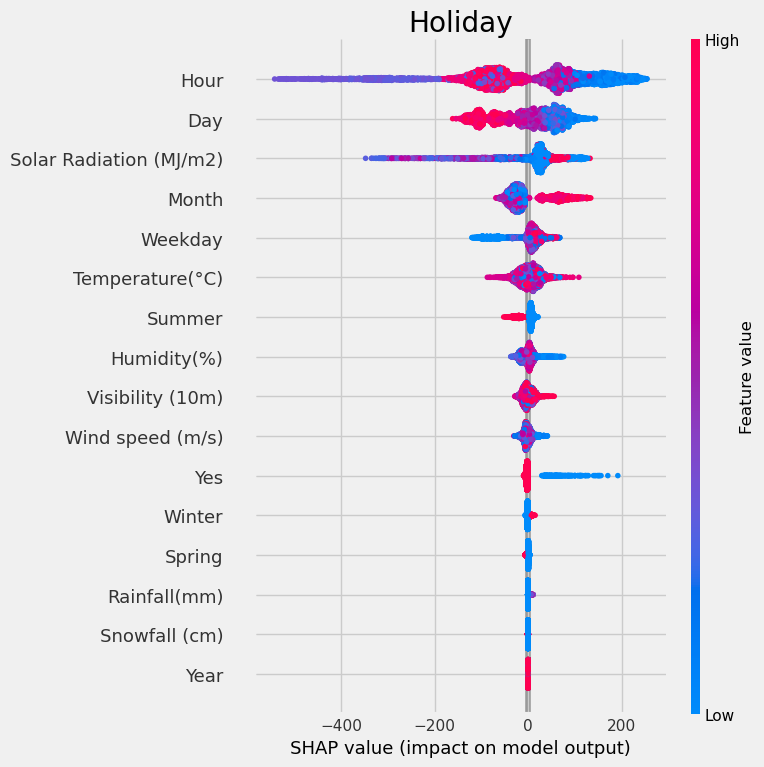

In [131]:
# shap_dict not specified
xlearner.plot_shap_values(X=X, tau=xlearner_tau, features=feature_names)

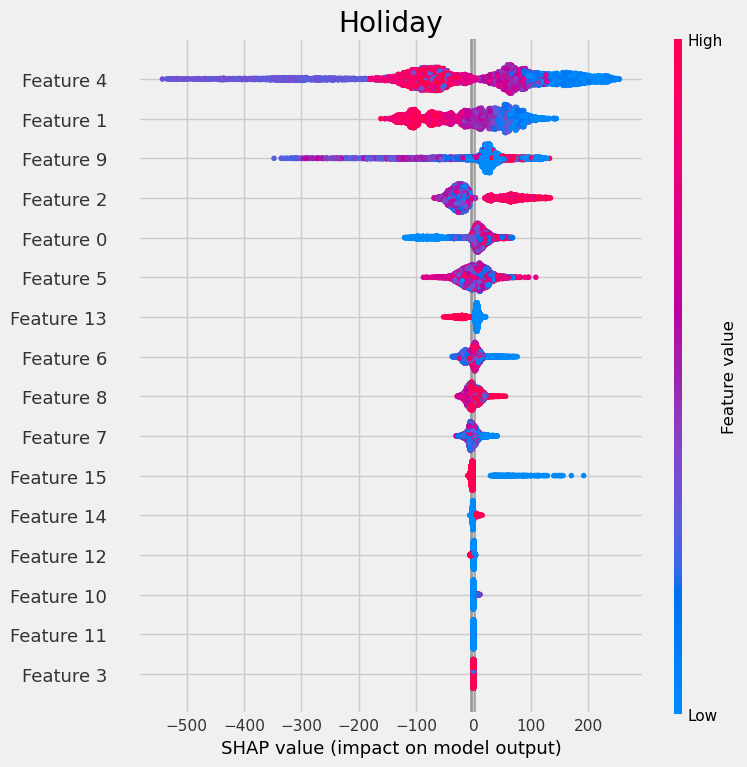

In [132]:
# shap_dict specified
xlearner.plot_shap_values(X=X, shap_dict=shap_xlearner)

### R Learner

In [134]:
rlearner = BaseRRegressor(LGBMRegressor(), control_name='control')
rlearner_tau = rlearner.fit_predict(X, multi_treatment, y)
rlearner.get_importance(X=X, 
                        tau=rlearner_tau, 
                        normalize=True, 
                        method='auto', 
                        features=feature_names)

{'Holiday': Day                        0.217956
 Temperature(°C)            0.172734
 Hour                       0.158937
 Visibility (10m)           0.086850
 Humidity(%)                0.084187
 Solar Radiation (MJ/m2)    0.081629
 Weekday                    0.070873
 Wind speed (m/s)           0.055762
 Month                      0.028424
 Summer                     0.015514
 Rainfall(mm)               0.013710
 Spring                     0.008587
 Yes                        0.003117
 Winter                     0.001556
 Snowfall (cm)              0.000163
 Year                       0.000000
 dtype: float64}

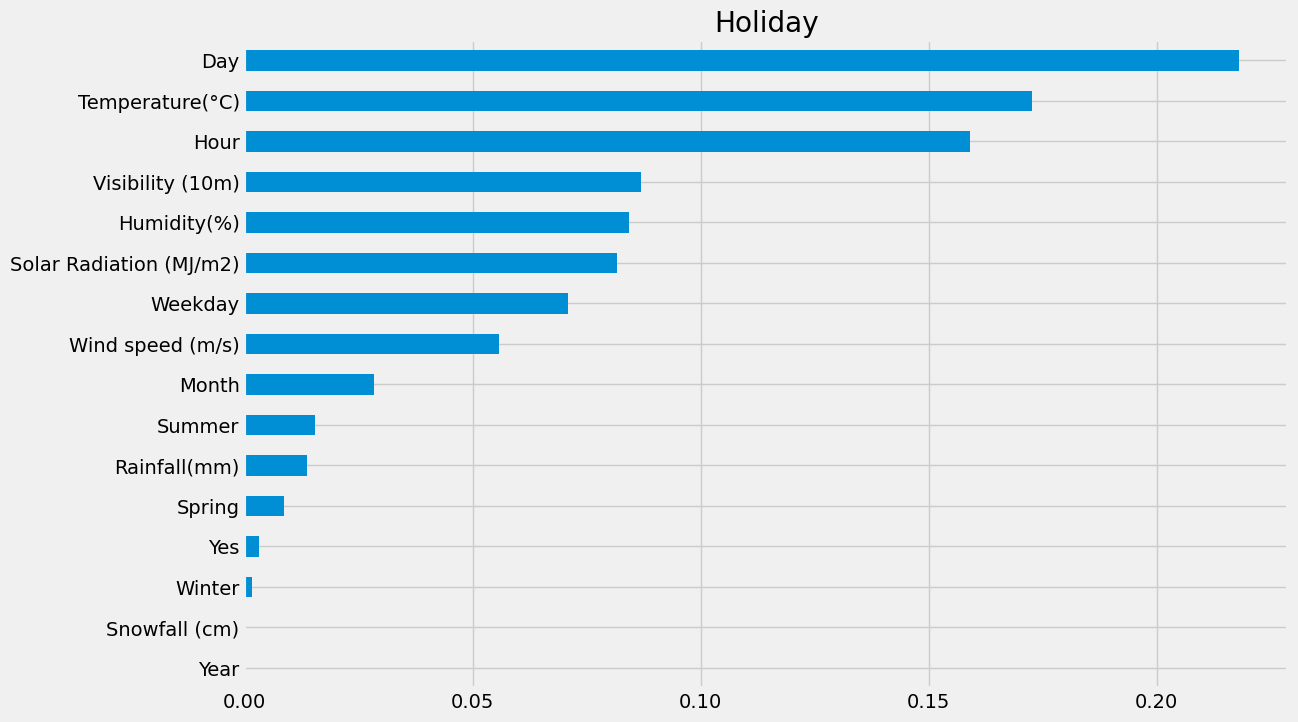

In [135]:
rlearner.plot_importance(X=X, 
                         tau=rlearner_tau, 
                         method='auto', 
                         features=feature_names)

In [136]:
rlearner.get_importance(X=X, 
                        tau=rlearner_tau, 
                        method='permutation', 
                        features=feature_names, 
                        random_state=119)

{'Holiday': Hour                       0.477684
 Humidity(%)                0.466518
 Temperature(°C)            0.362213
 Day                        0.275938
 Solar Radiation (MJ/m2)    0.232550
 Visibility (10m)           0.161364
 Weekday                    0.145299
 Wind speed (m/s)           0.085349
 Month                      0.061303
 Spring                     0.047557
 Rainfall(mm)               0.023505
 Summer                     0.006992
 Yes                        0.005982
 Snowfall (cm)              0.000840
 Winter                     0.000293
 Year                       0.000000
 dtype: float64}

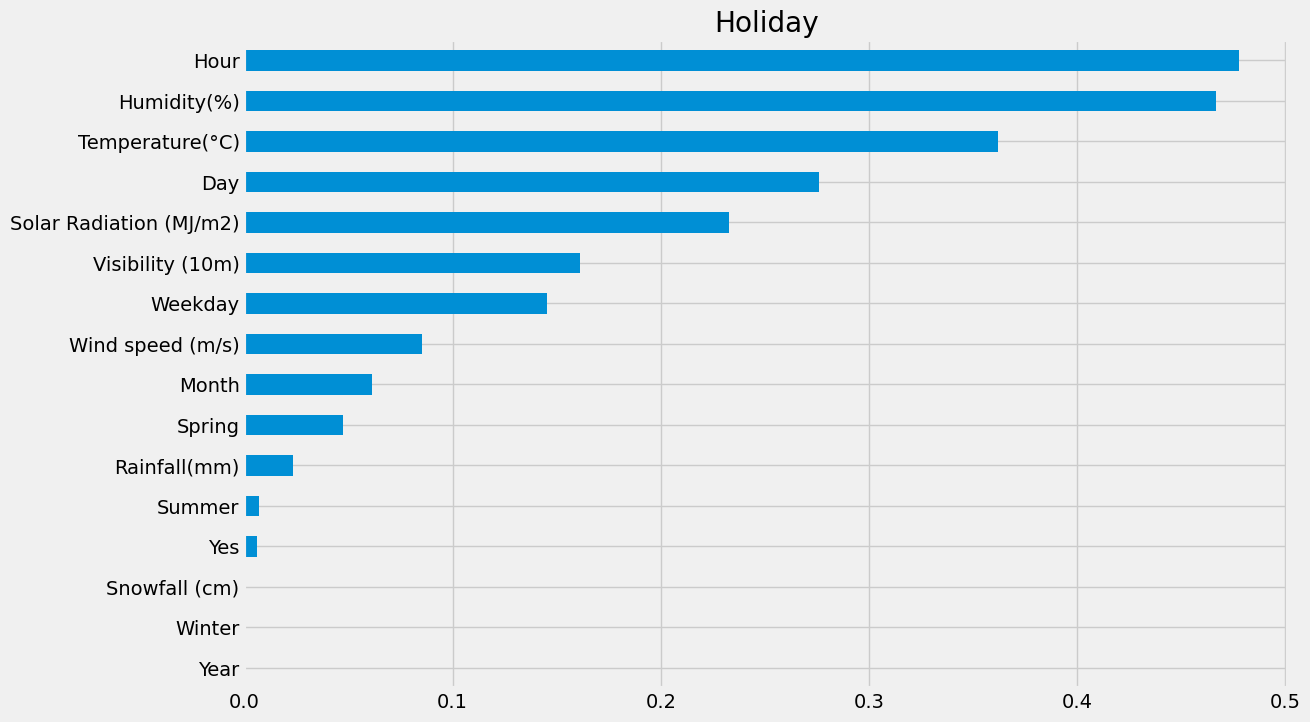

In [137]:
rlearner.plot_importance(X=X, 
                         tau=rlearner_tau, 
                         method='permutation', 
                         features=feature_names, 
                         random_state=119)

In [138]:
start_time = time.time()

X_train, X_test, y_train, y_test = train_test_split(X, rlearner_tau, test_size=0.3, random_state=42)
model_tau_fit = model_tau.fit(X_train, y_train)

perm_imp_test = permutation_importance(
    estimator=model_tau_fit, 
    X=X_test, 
    y=y_test, 
    random_state=42).importances_mean
pd.Series(perm_imp_test, feature_names).sort_values(ascending=False)

print("Elapsed time: %s seconds" % (time.time() - start_time))

Elapsed time: 0.296736478805542 seconds


In [139]:
pd.Series(perm_imp_test, feature_names).sort_values(ascending=False)

Hour                       0.430435
Humidity(%)                0.419466
Temperature(°C)            0.289627
Day                        0.278445
Solar Radiation (MJ/m2)    0.175703
Visibility (10m)           0.161026
Weekday                    0.112026
Wind speed (m/s)           0.074241
Spring                     0.062581
Month                      0.057889
Rainfall(mm)               0.007690
Yes                        0.005473
Summer                     0.005407
Winter                     0.000485
Snowfall (cm)              0.000205
Year                       0.000000
dtype: float64

Text(0.5, 1.0, 'Test Set Permutation Importances')

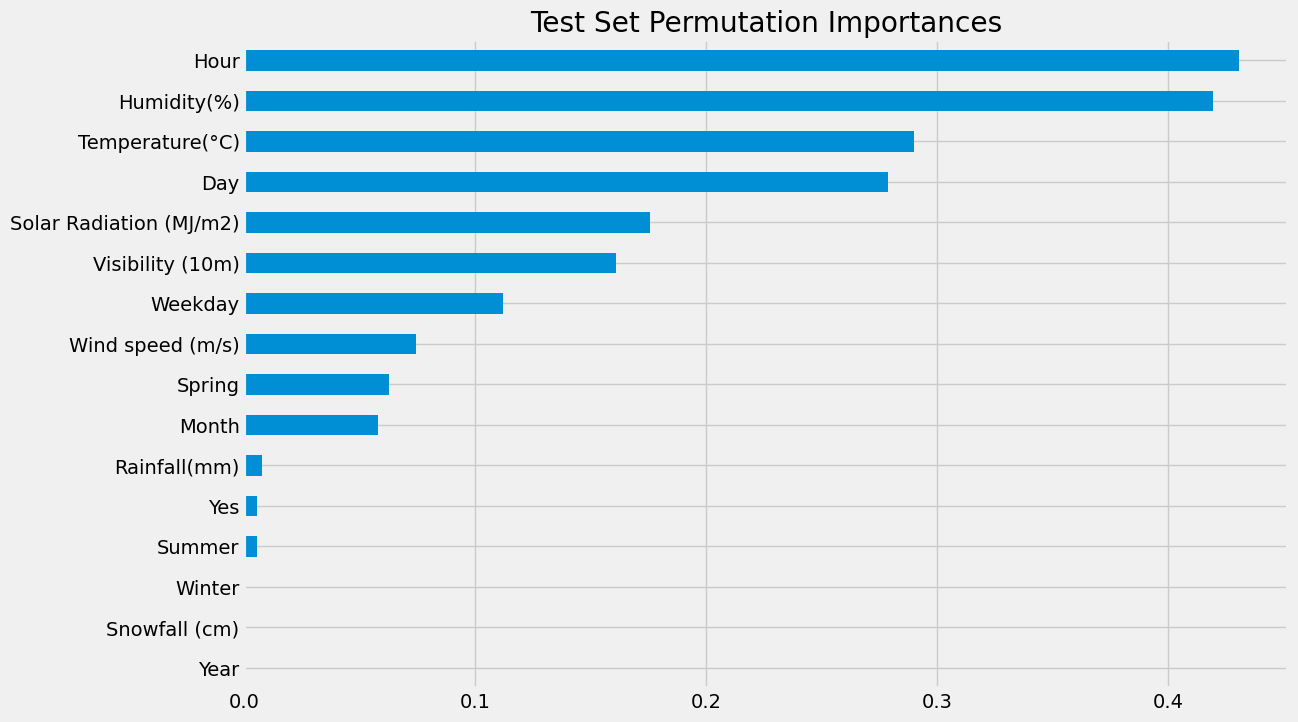

In [140]:
pd.Series(perm_imp_test, feature_names).sort_values().plot(kind='barh', figsize=(12, 8))
plt.title('Test Set Permutation Importances')

In [141]:
shap_rlearner = rlearner.get_shap_values(X=X, tau=rlearner_tau)
shap_rlearner

{'Holiday': array([[  -2.77785358,   29.36031165,   35.2078968 , ...,    2.62037912,
           -0.53453374,   -1.42283412],
        [ -93.70972344,   10.36732801,  119.00418351, ...,   15.46137523,
            0.44665709,    7.5949184 ],
        [  19.97095052,    2.15853223,  -56.77403459, ...,    9.33186454,
           -0.76643152,   -7.27101066],
        ...,
        [  22.5174686 ,  -20.88333163,   82.84110337, ...,   11.84334839,
           -1.62798612,   -0.89729848],
        [ -91.39217629, -139.7924692 ,  171.01771706, ...,    8.65245536,
            2.63849191,   -4.3002067 ],
        [ -36.87788807,  -19.06401285,   45.14176353, ...,   34.07617584,
           -1.58144482,   -2.45772287]])}

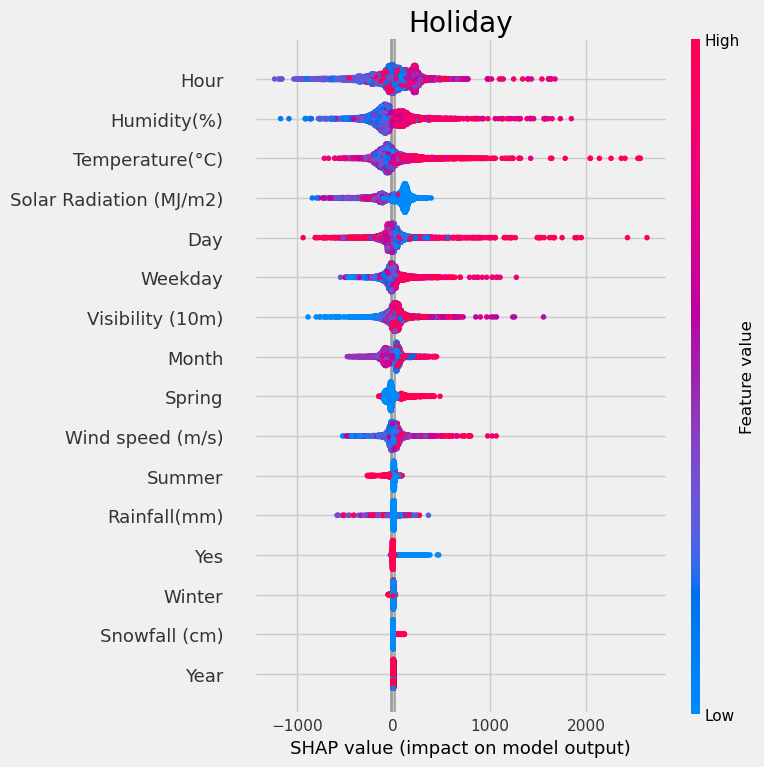

In [142]:
# without providing shap_dict
rlearner.plot_shap_values(X=X, tau=rlearner_tau, features=feature_names)

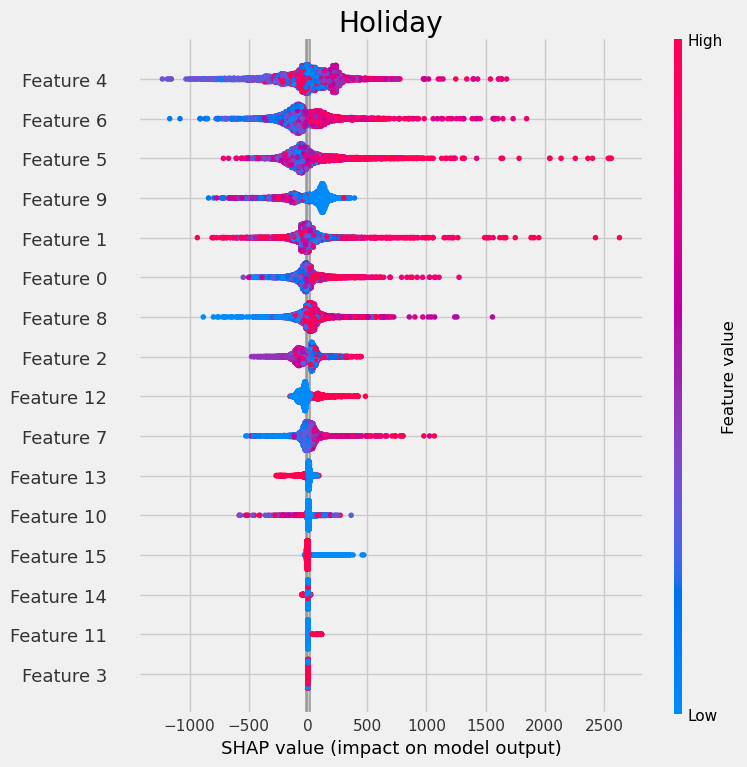

In [143]:
# with providing shap_dict
rlearner.plot_shap_values(X=X, shap_dict=shap_rlearner)

In [145]:
p_model = ElasticNetPropensityModel()
p = p_model.fit_predict(X, treatment)

In [146]:
s_learner = BaseSRegressor(LGBMRegressor())
s_ate = s_learner.estimate_ate(X, treatment, y)[0]
s_ite = s_learner.fit_predict(X, treatment, y)

t_learner = BaseTRegressor(LGBMRegressor())
t_ate = t_learner.estimate_ate(X, treatment, y)[0][0]
t_ite = t_learner.fit_predict(X, treatment, y)

x_learner = BaseXRegressor(LGBMRegressor())
x_ate = x_learner.estimate_ate(X, treatment, y, p)[0][0]
x_ite = x_learner.fit_predict(X, treatment, y, p)

r_learner = BaseRRegressor(LGBMRegressor())
r_ate = r_learner.estimate_ate(X, treatment, y, p)[0][0]
r_ite = r_learner.fit_predict(X, treatment, y, p)

In [148]:
from causalml.inference.tf import DragonNet
dragon = DragonNet(neurons_per_layer=200, targeted_reg=True)
dragon_ite = dragon.fit_predict(X, treatment, y, return_components=False)
dragon_ate = dragon_ite.mean()

Epoch 1/30
78/78 [==============================] - 2s 6ms/step - loss: 62592024.0000 - regression_loss: 31288034.0000 - binary_classification_loss: 265.0603 - treatment_accuracy: 0.1660 - track_epsilon: 0.0247 - val_loss: 25092248.0000 - val_regression_loss: 12377799.0000 - val_binary_classification_loss: 331.3745 - val_treatment_accuracy: 0.2153 - val_track_epsilon: 0.0360 - lr: 0.0010
Epoch 2/30
78/78 [==============================] - 0s 3ms/step - loss: 24830480.0000 - regression_loss: 12406686.0000 - binary_classification_loss: 339.6782 - treatment_accuracy: 0.2102 - track_epsilon: 0.0322 - val_loss: 23655926.0000 - val_regression_loss: 11698146.0000 - val_binary_classification_loss: 328.8957 - val_treatment_accuracy: 0.2169 - val_track_epsilon: 0.0281 - lr: 0.0010
Epoch 3/30
78/78 [==============================] - 0s 3ms/step - loss: 23459158.0000 - regression_loss: 11726805.0000 - binary_classification_loss: 336.1436 - treatment_accuracy: 0.2194 - track_epsilon: 0.0260 - val_l

Epoch 1/300
195/195 [==============================] - 0s 985us/step


In [152]:
df_preds = pd.DataFrame([s_ite.ravel(),
                          t_ite.ravel(),
                          x_ite.ravel(),
                          r_ite.ravel(),
                          dragon_ite.ravel(),
                          treatment.ravel(),
                          y.ravel()],
                       index=['S','T','X','R','dragonnet','w','y']).T

df_cumgain = get_cumgain(df_preds)

In [157]:
df_result = pd.DataFrame([s_ate, t_ate, x_ate, r_ate, dragon_ate],
                     index=['S','T','X','R','dragonnet'], columns=['ATE'])
df_result['MAE'] = [mean_absolute_error(t,p) for t,p in [s_ite, t_ite, x_ite, r_ite, dragon_ite]
                ] + [None]
df_result['AUUC'] = auuc_score(df_preds)

ValueError: too many values to unpack (expected 2)